# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1200s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1460, 32, 20, 3)
(1460, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
365/365 [==============================] - 5s 12ms/step - loss: 2.1578 - accuracy: 0.3183
Epoch 2/500
365/365 [==============================] - 5s 13ms/step - loss: 1.1774 - accuracy: 0.6268
Epoch 3/500
365/365 [==============================] - 4s 11ms/step - loss: 0.7963 - accuracy: 0.7316
Epoch 4/500
365/365 [==============================] - 4s 12ms/step - loss: 0.6352 - accuracy: 0.8018
Epoch 5/500
365/365 [==============================] - 5s 13ms/step - loss: 0.6271 - accuracy: 0.8177
Epoch 6/500
365/365 [==============================] - 5s 12ms/step - loss: 0.4849 - accuracy: 0.8393
Epoch 7/500
365/365 [==============================] - 4s 12ms/step - loss: 0.4715 - accuracy: 0.8678
Epoch 8/500
365/365 [==============================] - 4s 12ms/step - loss: 0.4002 - accuracy: 0.8746
Epoch 9/500
365/365 [==============================] - 4s 11ms/step - loss: 0.4143 - accuracy: 0.8607
Epoch 10/500
365/365 [==============================] - 5s 13ms/step - loss: 0.289

365/365 [==============================] - 4s 11ms/step - loss: 0.0447 - accuracy: 0.9837
Epoch 79/500
365/365 [==============================] - 4s 12ms/step - loss: 0.1009 - accuracy: 0.9772
Epoch 80/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0455 - accuracy: 0.9881 1s - ETA
Epoch 81/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0526 - accuracy: 0.9829
Epoch 82/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0400 - accuracy: 0.9907
Epoch 83/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0733 - accuracy: 0.9825
Epoch 84/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0472 - accuracy: 0.9876
Epoch 85/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0455 - accuracy: 0.9862
Epoch 86/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0223 - accuracy: 0.9928
Epoch 87/500
365/365 [==============================] - 4s 11ms/step - loss: 

365/365 [==============================] - 4s 11ms/step - loss: 0.0245 - accuracy: 0.9946
Epoch 157/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0140 - accuracy: 0.9948
Epoch 158/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0347 - accuracy: 0.9941
Epoch 159/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0374 - accuracy: 0.9909
Epoch 160/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0331 - accuracy: 0.9907
Epoch 161/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0388 - accuracy: 0.9905
Epoch 162/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0394 - accuracy: 0.9894
Epoch 163/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0685 - accuracy: 0.9846 0s - loss: 0.0720 
Epoch 164/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0285 - accuracy: 0.9919
Epoch 165/500
365/365 [==============================] - 4s

365/365 [==============================] - 4s 11ms/step - loss: 0.0072 - accuracy: 0.9982
Epoch 234/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0118 - accuracy: 0.9974
Epoch 235/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0205 - accuracy: 0.9957
Epoch 236/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0080 - accuracy: 0.9974
Epoch 237/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0024 - accuracy: 1.0000 0s - loss: 0.0024 - accuracy: 1.00
Epoch 238/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0103 - accuracy: 0.9960
Epoch 239/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0080 - accuracy: 0.9971
Epoch 240/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0210 - accuracy: 0.9975
Epoch 241/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0034 - accuracy: 0.9987
Epoch 242/500
365/365 [====================

365/365 [==============================] - 4s 11ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 311/500
365/365 [==============================] - 5s 12ms/step - loss: 0.0096 - accuracy: 0.9951
Epoch 312/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0052 - accuracy: 0.9984
Epoch 313/500
365/365 [==============================] - 5s 13ms/step - loss: 0.0139 - accuracy: 0.9973
Epoch 314/500
365/365 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.9978
Epoch 315/500
365/365 [==============================] - 5s 12ms/step - loss: 0.0115 - accuracy: 0.9948
Epoch 316/500
365/365 [==============================] - 4s 12ms/step - loss: 0.0066 - accuracy: 0.9977
Epoch 317/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0164 - accuracy: 0.9957
Epoch 318/500
365/365 [==============================] - 4s 11ms/step - loss: 0.0183 - accuracy: 0.9977
Epoch 319/500
365/365 [==============================] - 4s 11ms/step - loss: 

365/365 [==============================] - 3s 7ms/step - loss: 0.0037 - accuracy: 0.9988
Epoch 388/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0198 - accuracy: 0.9940
Epoch 389/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0267 - accuracy: 0.9929
Epoch 390/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 391/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0157 - accuracy: 0.9964
Epoch 392/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0104 - accuracy: 0.9968
Epoch 393/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0212 - accuracy: 0.9964
Epoch 394/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0290 - accuracy: 0.9955
Epoch 395/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0082 - accuracy: 0.9994
Epoch 396/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0017 - a

365/365 [==============================] - 2s 7ms/step - loss: 0.0072 - accuracy: 0.9975: 0s - loss: 0.0051 - 
Epoch 467/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0344 - accuracy: 0.9924
Epoch 468/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0098 - accuracy: 0.9958
Epoch 469/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 470/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0256 - accuracy: 0.9964
Epoch 471/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0222 - accuracy: 0.9966
Epoch 472/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0209 - accuracy: 0.9947
Epoch 473/500
365/365 [==============================] - 2s 7ms/step - loss: 0.1228 - accuracy: 0.9939
Epoch 474/500
365/365 [==============================] - 2s 6ms/step - loss: 0.0075 - accuracy: 0.9984
Epoch 475/500
365/365 [==============================] - 2s 6ms/s

### Learing result
 
* Visualization of the training and validation results

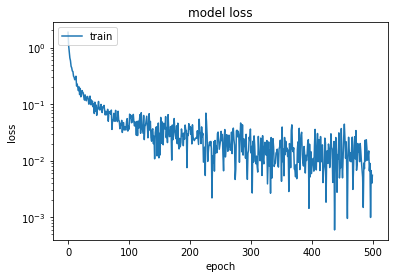

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


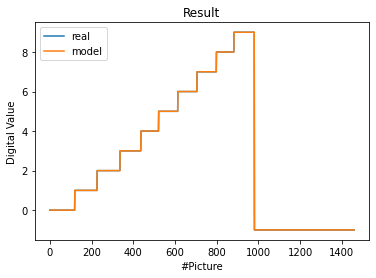

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmprod4ge5z\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp9kaqv19i\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp9kaqv19i\assets


dig1200s1q.tflite


203200

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.